In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
import warnings
warnings.filterwarnings('ignore')

In [2]:
money = pd.read_csv('../Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)

In [3]:
money.index.freq = 'MS'

In [4]:
spending = pd.read_csv('../Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)

In [5]:
spending.index.freq = 'MS'

In [6]:
df = money.join(spending)

In [7]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [8]:
df.tail()

,Money,Spending
Date,,
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1
2015-11-01,12277.4,12450.1
2015-12-01,12335.9,12469.1


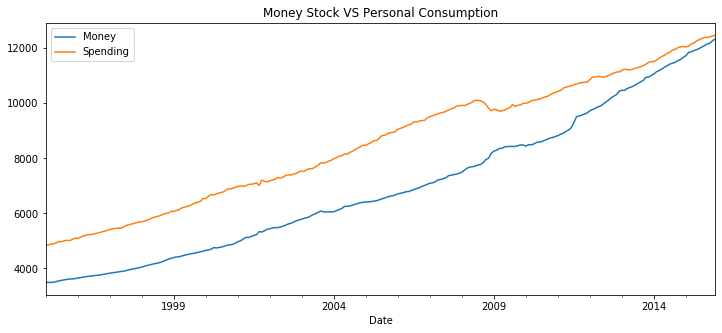

In [9]:
df.plot(title='Money Stock VS Personal Consumption')
plt.legend();

# Stationarity Test

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
for i in df.columns:
    print(adf_test(df[i], i))
    print()

Augmented Dickey-Fuller Test: Money
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None

Augmented Dickey-Fuller Test: Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None



In [12]:
from statsmodels.tsa.statespace.tools import diff

In [13]:
transformed_df = diff(df[['Money', 'Spending']], k_diff=1)

In [14]:
for i in df.columns:
    print(adf_test(transformed_df[i], i))
    print()

Augmented Dickey-Fuller Test: Money
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None

Augmented Dickey-Fuller Test: Spending
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None



In [15]:
transformed_df = diff(df[['Money', 'Spending']], k_diff=2)

In [16]:
for i in df.columns:
    print(adf_test(transformed_df[i], i))
    print()

Augmented Dickey-Fuller Test: Money
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None

Augmented Dickey-Fuller Test: Spending
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None



In [17]:
transformed_df.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [18]:
len(transformed_df)

250

In [19]:
# TRAIN TEST SPLIT

In [20]:
nob = 12

In [21]:
train = transformed_df.iloc[:-nob]

In [22]:
test = transformed_df.iloc[-nob:]

In [23]:
# VAR p selection

In [24]:
from statsmodels.tsa.api import VAR

In [25]:
AIC = []
for i in range(8):
    model=VAR(train)
    fitted = model.fit(i)
    AIC.append(fitted.aic)

In [26]:
p = pd.DataFrame(AIC, index=range(8), columns=['aic']).idxmin().values[0]

In [27]:
# MODEL

In [28]:
model = VAR(train)

In [29]:
result = model.fit(p)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Jul, 2020
Time:                     17:39:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [30]:
np.array(train.iloc[-p:])

array([[-31.9,  40.3],
       [  5.6, -70.7],
       [ 25.5,  52.5],
       [-21.3, -37.2],
       [ 39.5, -17.8]])

In [31]:
predictions = result.forecast(np.array(train.iloc[-p:]), steps=12)

In [32]:
predictions

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [33]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [34]:
idx = pd.date_range('2015-1-1', freq='MS', periods=12)

df_pred = pd.DataFrame(predictions, index=idx, columns=['Money_2d', 'Spending_2d'])

In [35]:
df_pred

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [36]:
# Inverse diff

In [37]:
df_pred['Money_1d'] = (df['Money'].iloc[-nob-1]-df['Money'].iloc[-nob-2]) + df_pred['Money_2d'].cumsum()

df_pred['Money'] = (df['Money'].iloc[-nob-1]) + df_pred['Money_1d'].cumsum()

In [38]:
df_pred['Spending_1d'] = (df['Spending'].iloc[-nob-1]-df['Spending'].iloc[-nob-2]) + df_pred['Spending_2d'].cumsum()

df_pred['Spending'] = (df['Spending'].iloc[-nob-1]) + df_pred['Spending_1d'].cumsum()

In [39]:
# Plot results

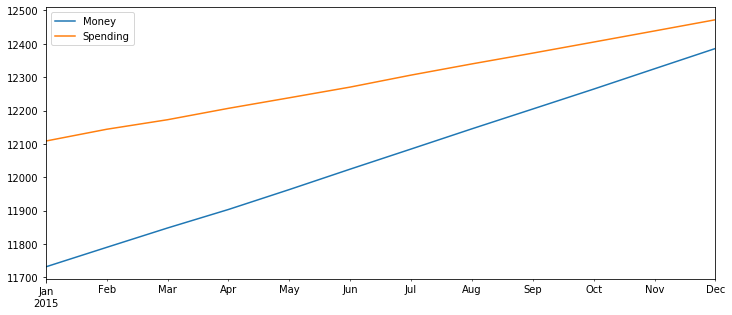

In [40]:
df_pred[['Money', 'Spending']].plot();

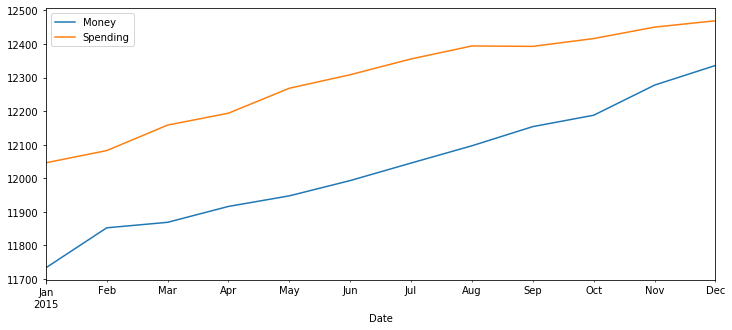

In [41]:
df.iloc[-12:].plot();

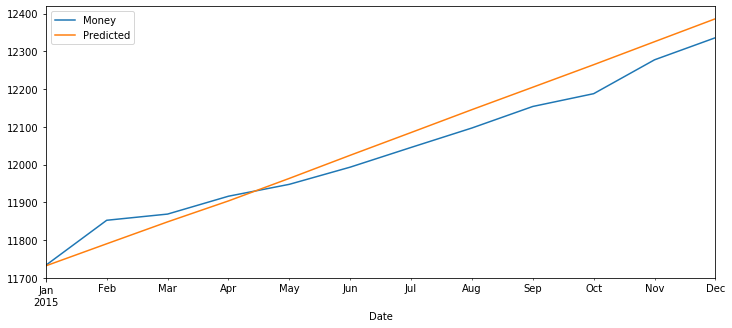

In [42]:
df.iloc[-12:]['Money'].plot()
df_pred['Money'].plot(label='Predicted')
plt.legend()
plt.show()

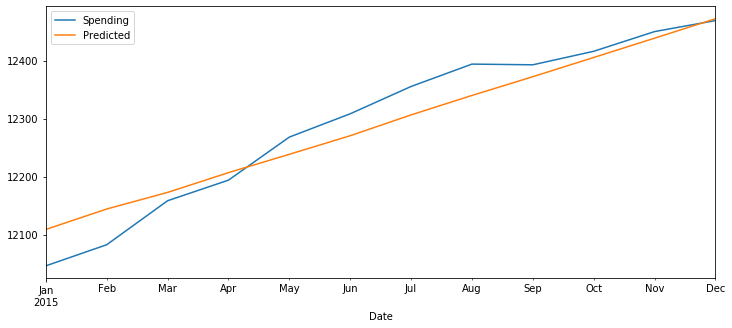

In [43]:
df.iloc[-12:]['Spending'].plot()
df_pred['Spending'].plot(label='Predicted')
plt.legend()
plt.show()

In [44]:
from statsmodels.tools.eval_measures import rmse

In [45]:
for i in df.columns:
    print('VAR ' + i + ': {}\n'.format(rmse(df[i].iloc[-12:], df_pred[i])))

VAR Money: 43.71049653558938

VAR Spending: 37.00117516940808



# AR Model

# Money

In [46]:
money.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [47]:
train_m = money.iloc[:-12]
test_m = money.iloc[-12:]

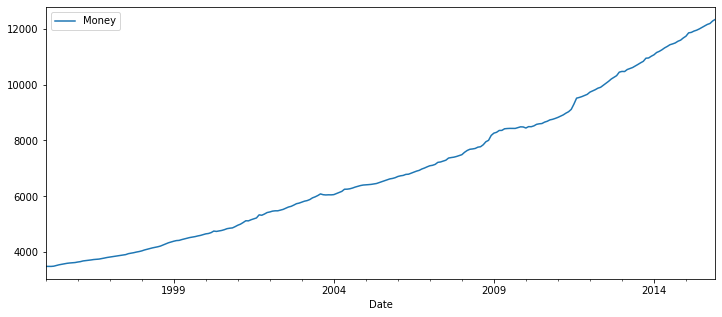

In [48]:
money.plot();

In [49]:
from statsmodels.tsa.ar_model import AR

In [50]:
# Model

In [51]:
model_m = AR(train_m['Money'])

In [52]:
fitted_m = model_m.fit(ic='t-stat')

In [53]:
print('Max Lags: {}\n'.format(fitted_m.k_ar))
print('Cofficients :\n{}'.format(fitted_m.params))


Max Lags: 5

Cofficients :
const      -0.685604
L1.Money    1.251564
L2.Money   -0.205590
L3.Money    0.115844
L4.Money   -0.308751
L5.Money    0.150644
dtype: float64


In [54]:
pred_m = fitted_m.predict(len(train_m), len(money)-1, dynamic=False).rename('AR Money Stocks prediction')

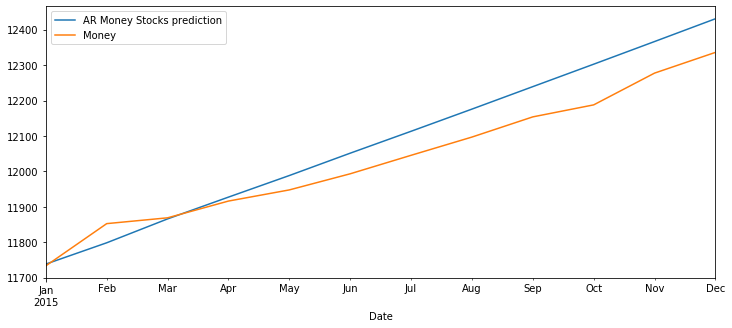

In [55]:
pred_m.plot()
test_m['Money'].plot()
plt.legend();


In [56]:
print('RMSE money: {}'.format(rmse(test_m['Money'], pred_m)))

RMSE money: 68.55572870799008


# Spending

In [57]:
spending.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [58]:
train_s = spending.iloc[:-12]
test_s = spending.iloc[-12:]

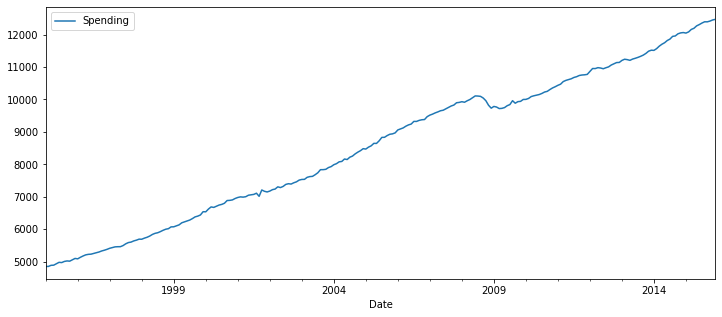

In [59]:
spending.plot();

In [60]:
model_s = AR(train_s['Spending'])

In [61]:
fitted_s = model_s.fit(ic='t-stat')

In [62]:
print('Max Lags: {}\n'.format(fitted_s.k_ar))
print('Cofficients :\n{}'.format(fitted_s.params))

Max Lags: 4

Cofficients :
const          21.845773
L1.Spending     0.990801
L2.Spending     0.152032
L3.Spending    -0.013445
L4.Spending    -0.129318
dtype: float64


In [63]:
pred_s = fitted_s.predict(len(train_s), len(spending)-1, dynamic=False).rename('AR Spending prediction')

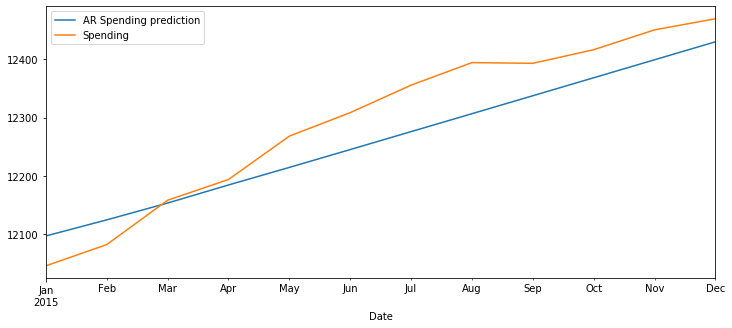

In [64]:
pred_s.plot()
test_s['Spending'].plot()
plt.legend();


In [65]:
print('RMSE Spending: {}'.format(rmse(test_s['Spending'], pred_s)))

RMSE Spending: 53.959531106660606
